In [1]:
from model import Model
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from data_loader import SeqDataLoader
from predict import run_epoch

/home/biaoxue/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# default output path
output_dir = 'output'
# first subject
subject_idx = 0
# checkpoint path
ckpt_pth = os.path.join(output_dir, 'fold{}'.format(subject_idx), 'staging')
# first subject's recording
recording = 'MASS/eeg_f4/SS3/01-03-0001.npz'

flags = tf.app.flags 
FLAGS = tf.app.flags.FLAGS
FLAGS.dataset = 'MASS'
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [3]:
# load subject recording
x, y, _ = SeqDataLoader._load_npz_file(recording)
# Reshape the data to match the input of the model - conv2d
x = np.squeeze(x)
x = x[:, :, np.newaxis, np.newaxis]

# Casting
x = [x.astype(np.float32)]
y = [y.astype(np.int32)]

filter_size: 77, stride: 7, pool1_size: 7, pool2_size: 22
INFO:tensorflow:Restoring parameters from output/fold0/staging/model_fold0.ckpt-100
Saved outputs to output/output_subject0.npz


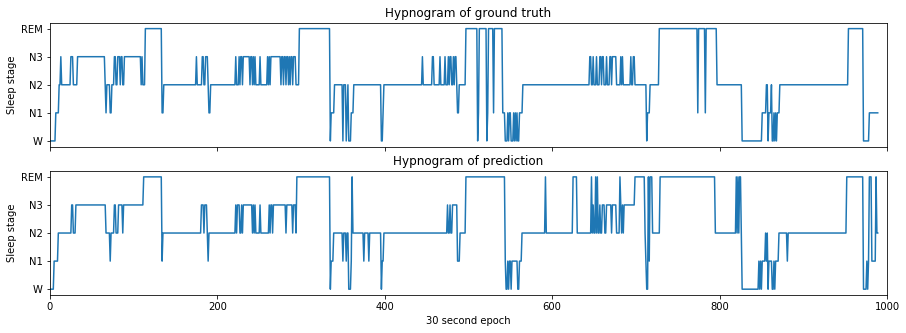

In [4]:
# load check point
with tf.Graph().as_default(), tf.Session() as sess:
    valid_net = Model(
        batch_size=1,
        input_dims=30*256,
        n_classes=5,
        seq_length=30,
        is_train=False,
        reuse_params=False
    )
    valid_net.init_ops()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(ckpt_pth))
    y_true, y_pred, _, _ = run_epoch(
                    sess=sess, network=valid_net,
                    inputs=x, targets=y,
                    train_op=tf.no_op(),
                    output_dir=output_dir,
                    subject_idx=subject_idx
                )
    f, axarr = plt.subplots(2, sharex=True)
    f.set_figheight(5)
    f.set_figwidth(15)
    plt.setp(axarr, yticks=[0, 1, 2, 3, 4], yticklabels=['W', 'N1', 'N2', 'N3', 'REM'],
             ylabel='Sleep stage')
    axarr[0].plot(y_true)
    axarr[0].set_title('Hypnogram of ground truth')
    axarr[0].axis([0, 1000, -0.2, 4.2])

    axarr[1].plot(y_pred)
    axarr[1].set_title('Hypnogram of prediction')
    axarr[1].set_xlabel('30 second epoch')
    axarr[1].axis([0, 1000, -0.2, 4.2])
    plt.savefig('hypnogram.jpg', dpi=300)
    plt.show()